## **Preface**
Building on the success of hybrid models in existing literature on similar cancer classification tasks **(e.g., Gupta et al., 2022)**, this approach explores the use of logistic regression alongside gradient-boosted trees for a more nuanced understanding of the data and improved classification accuracy.

 Prior models, such as hybrid CNN and SVM methods **(Khairandish, 2021)**, showed promising results but lacked extensive validation across different datasets. This implementation employs cross-validation to ensure reliable performance metrics and reduce overfitting risk.

 Given the large number of features (350) in our data, one of the few sensible modes of EDA we can conduct is a correlation heatmap, as shown below.




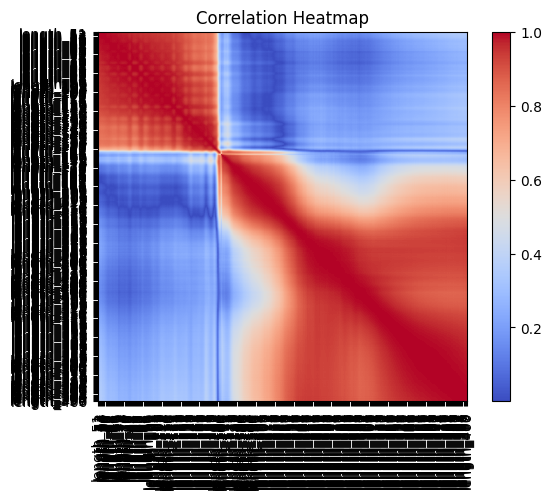

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, PredefinedSplit
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

train = pd.read_csv('Train_Set.csv')
test = pd.read_csv('Test_Set.csv')
X_train = train.iloc[:, :-1]  # all rows, all columns except the last (features)
y_train = train.iloc[:, -1]   # all rows, only the last column (target)
X_test = test.iloc[:, :-1]  # same for the test set
y_test = test.iloc[:, -1]   # target for test set

corr_matrix = X_train.corr().abs() #calculate correlation matrix
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Create a figure and axes
fig, ax = plt.subplots()
# Display the heatmap using imshow
im = ax.imshow(corr_matrix, cmap='coolwarm')
# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)
# Set the ticks and labels
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=90)
ax.set_yticklabels(corr_matrix.columns)
# Add title
plt.title('Correlation Heatmap')
# Show the plot
plt.show()



## **Baseline reference with logistic regression**
We first fit a logistic regression model on the raw data without any  preprocessing/data transformation, just to get a rough idea of what we can achieve.

In [12]:

print("############ baseline reference for logistic regression ##############")
# Initialize and train the logistic regression model
log_reg = LogisticRegression(random_state=0)
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


############ baseline reference for logistic regression ##############
Classification Report:
              precision    recall  f1-score   support

      cancer       0.90      1.00      0.95       368
     healthy       0.00      0.00      0.00        41

    accuracy                           0.90       409
   macro avg       0.45      0.50      0.47       409
weighted avg       0.81      0.90      0.85       409



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **1.1: Feature Selection + Dimensionality reduction (PCA)**
Here, we drop feature pairs with relatively high correlation values. We then perform PCA(Principal Component Analysis) transformation on the data.

In [13]:
# Find features with correlation greater than threshold and drop them
threshold = 0.999 # only in the 0.999s can I achieve a significant drop in the number of features
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
X_train_filtered = X_train.drop(to_drop, axis=1)
X_test_filtered = X_test.drop(to_drop, axis=1)
print()
#features remaining after removing high correlated variables
remaining_features_train = X_train_filtered.columns.tolist()



# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

# Apply PCA
pca = PCA(n_components=0.9999)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
n_components = pca.n_components_
print(f'Number of PCA components: {n_components}')



Number of PCA components: 52


## **1.2: (Approach 1) Logistic Regression on PCA components**



Severe (healthy) class imbalance addressed via adjusting minority weights

In [14]:

# Initialize Logistic Regression model
print('############ Training Logistic Regression on PCA Components - Class imbalance addressed only by adjusting minority weights ############')
print('------------------------------------------------------------')
class_weights = {'cancer': 1, 'healthy': 14}
# giving 14 times as much weight to healthy class to handle class imbalance
log_reg = LogisticRegression(random_state=0, class_weight=class_weights, max_iter = 300)

# Perform n-fold cross-validation
n_folds = 10  # Adjust the number of folds as needed
cv_scores = cross_val_score(log_reg, X_train_pca, y_train, cv=n_folds)
# Create a DataFrame for cross-validation scores
cv_scores_df = pd.DataFrame(cv_scores, columns=['Cross-Validation Score'])
cv_scores_df.index += 1  # Start index at 1 for better readability
# Print the cross-validation scores in a neat table format
print(cv_scores_df)
print(f'\nMean Cross-validation Score: {np.mean(cv_scores):.4f}')


# Train the model on the PCA-transformed training data
log_reg.fit(X_train_pca, y_train)
# Make predictions on the PCA-transformed test data
y_pred = log_reg.predict(X_test_pca)


print('------------------------------------------------------------')

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)
# Classification Report
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

############ Hyperparameter tuning ############
print('------------------------------------------------------------')
print('############ Hyperparameter tuning ############')
# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [10000]
}

best_score = 0
best_params = {}

# Loop through each combination of hyperparameters
for C in param_grid['C']:
    for penalty in param_grid['penalty']:
        for solver in param_grid['solver']:
            if penalty == 'l1' and solver != 'liblinear':  # Avoid incompatible combinations
                continue

            # Train the model with the current hyperparameter set
            model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=10000, class_weight={'cancer': 1, 'healthy': 14})
            model.fit(X_train_pca, y_train)

            # Evaluate on a separate validation set
            y_val_pred = model.predict(X_test_pca)  # Using X_test_pca as validation set for simplicity
            score = accuracy_score(y_test, y_val_pred)

            # Track the best hyperparameters
            if score > best_score:
                best_score = score
                best_params = {'C': C, 'penalty': penalty, 'solver': solver}

print("Best Parameters:", best_params)
print("Best Validation Score:", best_score)




############ Training Logistic Regression on PCA Components - Class imbalance addressed only by adjusting minority weights ############
------------------------------------------------------------
    Cross-Validation Score
1                 0.705882
2                 0.821429
3                 0.845238
4                 0.928571
5                 0.714286
6                 0.880952
7                 0.797619
8                 0.595238
9                 0.857143
10                0.761905

Mean Cross-validation Score: 0.7908
------------------------------------------------------------
Accuracy: 0.8141809290953546
Confusion Matrix:
[[299  69]
 [  7  34]]
Classification Report:
              precision    recall  f1-score   support

      cancer       0.98      0.81      0.89       368
     healthy       0.33      0.83      0.47        41

    accuracy                           0.81       409
   macro avg       0.65      0.82      0.68       409
weighted avg       0.91      0.81      0.85

## **2.1: (Approach 2) Logistic Regression on SMOTE'd data (No dimensionality reduction)**
Unlike approach 1, we attempt to address class imbalance here by instead applying SMOTE(Synthetic Minority Oversampling Technique) to the data. Although this method is quite frowned upon by the wider ML community, we thought it was worth a try.


In [15]:

print("################## Logistic regression with SMOTE'ed data #########################")
# Apply SMOTE to the training data
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

log_reg = LogisticRegression(random_state=0, max_iter=300)

# Perform cross-validation on the resampled data
n_folds = 10
cv_scores = cross_val_score(log_reg, X_train_resampled, y_train_resampled, cv=n_folds)
cv_scores_df = pd.DataFrame(cv_scores, columns=['Cross-Validation Score'])
cv_scores_df.index += 1
print(cv_scores_df)
print(f'\nMean Cross-validation Score: {np.mean(cv_scores):.4f}')

log_reg.fit(X_train_resampled, y_train_resampled)

y_pred = log_reg.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

################## Logistic regression with SMOTE'ed data #########################
    Cross-Validation Score
1                 0.802548
2                 0.866242
3                 0.910256
4                 0.974359
5                 0.839744
6                 0.929487
7                 0.903846
8                 0.794872
9                 0.935897
10                0.865385

Mean Cross-validation Score: 0.8823
Accuracy: 0.8337408312958435
Confusion Matrix:
[[308  60]
 [  8  33]]
Classification Report:
              precision    recall  f1-score   support

      cancer       0.97      0.84      0.90       368
     healthy       0.35      0.80      0.49        41

    accuracy                           0.83       409
   macro avg       0.66      0.82      0.70       409
weighted avg       0.91      0.83      0.86       409



## **3.1: (Approach 3) Gradient boosted trees - XGB**

In [16]:
################ Gradient Boosted Trees #####################
print("------------------------------------------------------------")
print("############ Gradient Boosted Trees ############")
y_train = y_train.map({'cancer': 1, 'healthy': 0})
y_test = y_test.map({'cancer': 1, 'healthy': 0})
gb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
gb_model.fit(X_train, y_train)

# Make predictions
y_pred = gb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, digits=3)

# Extract True Negatives, False Positives, False Negatives, and True Positives from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate specificity, MCC, and FNR
specificity = tn / (tn + fp)
mcc = ((tp * tn) - (fp * fn)) / ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
fnr = fn / (fn + tp)

# Print results
print(f'Accuracy: {accuracy:.3f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)
print(f'Specificity: {specificity:.3f}')
print(f'MCC: {mcc:.3f}')
print(f'FNR: {fnr:.3f}')

------------------------------------------------------------
############ Gradient Boosted Trees ############


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:22:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.914
Confusion Matrix:
[[ 19  22]
 [ 13 355]]
Classification Report:
              precision    recall  f1-score   support

           0      0.594     0.463     0.521        41
           1      0.942     0.965     0.953       368

    accuracy                          0.914       409
   macro avg      0.768     0.714     0.737       409
weighted avg      0.907     0.914     0.910       409

Specificity: 0.463
MCC: 0.479
FNR: 0.035
